In [ ]:
!pip install python-telegram-bot

In [18]:
import  time
import requests
import telegram
from flask import Flask, request
import json
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [19]:
TOKEN = "token"
PORT = 5000

# Определяем функции:

In [20]:
def read_server_url(): # вычитываем url выданный для нашего сервиса.
  with open('nohup.out', 'r') as f:
    return f.read().split(': ')[-1].split('\n')[0]

In [21]:
def make_api_url(method): 
  return f"https://api.telegram.org/bot{TOKEN}/{method}"

In [22]:
def set_webhook(server_url):
  api_url = make_api_url('setWebhook')
  post_data = {
      "url": server_url,
      }
  x = requests.post(api_url, data = post_data, headers={'header': 'Content-Type: application/json'})
  return x.json()['ok']

In [23]:
def send_message(chat_id, text):
    method = "sendMessage"
    url = make_api_url(method)
    data = {"chat_id": chat_id, "text": text}
    requests.post(url, data=data)

In [24]:
def get_photo_path(photo_id, server_url):
  api_url = make_api_url('getFile')
  post_data = {
      'file_id': photo_id,
      "url": server_url,
      }
  x = requests.post(api_url, data = post_data, headers={'header': 'Content-Type: application/json'})
  return x.json()['result']['file_path']

In [25]:
def get_photo(photo_id, server_url):
  photo_path = get_photo_path(photo_id, server_url)
  photo_url = f'https://api.telegram.org/file/bot{TOKEN}/{photo_path}'
  return  Image.open(requests.get(photo_url, stream=True).raw)

In [26]:
def process_photo(photo):
  plt.subplots()
  plt.imshow(photo)
  return 'result'

# Модель segmentation

In [94]:
args = {
'IMAGE_H': 512,
'IMAGE_W': 512,
'LR': 0.0003,
'STEP_SIZE': 8,
'BATCH_SIZE': 4,
'EPOCHES': 20,
'DEVICE': 'cuda',
'ACTIVATION': 'sigmoid',
'ENCODER_DEPTH': 6,
'POOLING': 'avg',
'DROPOUT': 0.5,
'CLASSES': 1,
'DECODER_MODEL': 'resnet34',
'MODEL':'UNET',
'loss': 'BCE',
'SEED': 2020
}

In [95]:
import numpy as np
import torch
import cv2 as cv

In [96]:
from google.colab.patches import cv2_imshow

In [ ]:
!pip install segmentation_models_pytorch
from segmentation_models_pytorch import Unet

In [98]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [99]:
aux_params=dict(
    pooling=args['POOLING'],                 # one of 'avg', 'max'
    dropout=args['DROPOUT'],                 # dropout ratio, default is None
    activation=args['ACTIVATION'],           # activation function, default is None
    classes=args['CLASSES'],                 # define number of output labels
  )

model_segment = Unet(args['DECODER_MODEL'], encoder_weights=None, activation=args['ACTIVATION'], aux_params=aux_params)
#model.load_state_dict(torch.load('model.pt'))
model_segment.load_state_dict(torch.load('/content/drive/MyDrive/model.pt'))
model_segment.to(args['DEVICE']); 

In [100]:

from albumentations import *

In [101]:
def prepare_image(image_path, size):
  image = Image.open(image_path).convert('RGB')
  image = image.resize((size[1],size[0]), resample=Image.BILINEAR)
  image = np.array(image)
  #TO GREY!
  image_to_model = Compose([Normalize(), ToGray(1)])(image=image)['image']
  return image, image_to_model



In [102]:
def make_mask(model, image, device):
  tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0).to(device)
  mask = model(tensor)[0].squeeze().detach().cpu().numpy()
  return mask*255

In [103]:
def mask2crops(image, mask, threshold=0.5):
  _, binary = cv.threshold(mask, 255*threshold, 255, cv.THRESH_BINARY) 
  contours, hierarchy = cv.findContours(binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  croped_images = []
  
  for contour in contours:
    rect = cv.boundingRect(contour)
    if rect[3] <21 or rect[2] < 21:
      continue
    img_croped = image[rect[1]-5:rect[1]+rect[3]+5,rect[0]-5:rect[0]+rect[2]+5]
    if img_croped.shape[1] <1:
      continue
    croped_images.append(img_croped)
  return croped_images

In [104]:
def image2cropPipline(model, image_path, size, threshold=0.5, device='cuda'):
  '''
    На вход подается путь к картинке, на выход отдается list кропов (np.array) 
    разной длины, нужна постобработка Normalize() паддинги.
  '''
  image, model_image = prepare_image(image_path, size)
  mask = make_mask(model, model_image, device).astype(np.uint8)
  crops = mask2crops(image, mask, threshold)
  return crops[::-1], mask

# Препроцессинг OCR

In [ ]:
!git clone -l -s git://github.com/ZackPashkin/ocr_pytorch.git
!ls

In [ ]:
!wget https://storage.googleapis.com/comptech2021-ocr/synth_dataset.zip
!unzip -qq /content/synth_dataset.zip -d /content/

In [ ]:
# download real dataset 
!wget https://storage.googleapis.com/comptech2021-ocr/real_dataset.zip
!unzip -qq /content/real_dataset.zip -d /content/

In [ ]:
%%time

import glob
import os
import pandas as pd

df = pd.read_csv("real_dataset/HANDWRITTEN_5_folders.csv")
dfs = pd.read_csv("real_dataset/werner_real/annotation.csv", sep='\t', comment='#')

real_labels_dict = {}
for index,image_name in enumerate(glob.glob("real_dataset/HANDWRITTEN/*/*.png")):
  label = df.loc[df["INPUT:image"] == image_name[12:], "OUTPUT:output"]
  label = label.tolist()
  if label != []:
    tmp = 0
    #real_labels_dict.update({image_name:label[0]})
    
    for letter in label[0]:
      # (letter == '№') or (letter == 'N') or
      # (letter == '№') or (letter == '/') or (letter == 'S') => Label Classes = 91
      if  (letter == 'N') or (letter == 'F') or (letter == 'S'):
        tmp = tmp + 1
    if (tmp == 0):
      real_labels_dict.update({image_name:label[0]})
    
images_with_value = {}
for index, row in dfs.iterrows():
    split_row = row['0.png,суммарный'].split(",")
    tmp = 0
    #img_path = "real_dataset/werner_real/data/" + split_row[0]
    #images_with_value.update({img_path:split_row[1]})
    
    for letter in split_row[1]:
      # (letter == '№') or (letter == 'N') or 
      # (letter == '№') or (letter == '/') or (letter == 'S') => Label Classes = 91
      if  (letter == 'N') or (letter == 'F') or (letter == 'S'):
        tmp = tmp + 1
    if (tmp == 0):
      img_path = "real_dataset/werner_real/data/" + split_row[0]
      images_with_value.update({img_path:split_row[1]})
    

for index,image_name in enumerate(glob.glob("real_dataset/werner_real/data/*.png")):
  for key in images_with_value:
    if (image_name == key):
      real_labels_dict.update({key:images_with_value[key]})

print(len(real_labels_dict))

In [ ]:
%%time

synth_labels_dict = {}
synth_werner_list = []
synth_werner = open('synth_dataset/werner_synthetic/annotation.txt','r')
try:
   synth_werner_list = synth_werner.read().splitlines()
finally:
   synth_werner.close()

for index in range(len(synth_werner_list)):
  img_path = "synth_dataset/werner_synthetic/content/result/" + synth_werner_list[index].partition(',')[0]
  label = synth_werner_list[index].partition(',')[2]
  real_labels_dict.update({img_path:label})
  #if index == 30000: break

print(len(synth_labels_dict))

In [70]:
synth_werner_list = []
synth_werner = open('synth_dataset/werner_distorted/annotation.txt','r')
try:
   synth_werner_list = synth_werner.read().splitlines()
finally:
   synth_werner.close()

images_with_value = {}
for index in range(len(synth_werner_list)):
  img_path = "synth_dataset/werner_distorted/content/generated/" + synth_werner_list[index].rpartition(',')[2] + ".png"
  label = synth_werner_list[index].rpartition(',')[0]
  images_with_value.update({img_path:label})

for index,image_name in enumerate(glob.glob("synth_dataset/werner_distorted/content/generated/*.png")):
  for key in images_with_value:
    if (image_name == key):
      real_labels_dict.update({key:images_with_value[key]})

print(len(synth_labels_dict))

0


In [ ]:
%%time

synth_kovshov = pd.read_csv("synth_dataset/kovshov_synth_labels.csv" ,sep='|', encoding = 'cp1251')

#synth_labels_dict = {}
for index, row in synth_kovshov.iterrows():
    split_row = row['1.jpg;(1839-1843), реформа'].split(";")
    img_path = "synth_dataset/kovshov_synth_images/" + split_row[0]
    real_labels_dict.update({img_path:split_row[1]})

print(len(synth_labels_dict))

In [3]:
%%time

import glob
import os
import pandas as pd

df = pd.read_csv("real_dataset/HANDWRITTEN_5_folders.csv")
dfs = pd.read_csv("real_dataset/werner_real/annotation.csv", sep='\t', comment='#')

real_labels_dict = {}
for index,image_name in enumerate(glob.glob("real_dataset/HANDWRITTEN/*/*.png")):
  label = df.loc[df["INPUT:image"] == image_name[12:], "OUTPUT:output"]
  label = label.tolist()
  if label != []:
    tmp = 0
    #real_labels_dict.update({image_name:label[0]})
    
    for letter in label[0]:
      # (letter == '№') or (letter == 'N') or
      # (letter == '№') or (letter == '/') or (letter == 'S') => Label Classes = 91
      if (letter == '/') or (letter == '№') or (letter == 'N') or (letter == 'S') or (letter == 'I'):
        tmp = tmp + 1
    if (tmp == 0):
      real_labels_dict.update({image_name:label[0]})
    
images_with_value = {}
for index, row in dfs.iterrows():
    split_row = row['0.png,суммарный'].split(",")
    tmp = 0
    #img_path = "real_dataset/werner_real/data/" + split_row[0]
    #images_with_value.update({img_path:split_row[1]})
    
    for letter in split_row[1]:
      # (letter == '№') or (letter == 'N') or 
      # (letter == '№') or (letter == '/') or (letter == 'S') => Label Classes = 91
      if (letter == '/') or (letter == '№') or (letter == 'N') or (letter == 'S') or (letter == 'I'):
        tmp = tmp + 1
    if (tmp == 0):
      img_path = "real_dataset/werner_real/data/" + split_row[0]
      images_with_value.update({img_path:split_row[1]})
    

for index,image_name in enumerate(glob.glob("real_dataset/werner_real/data/*.png")):
  for key in images_with_value:
    if (image_name == key):
      real_labels_dict.update({key:images_with_value[key]})

print(len(real_labels_dict))

4214
CPU times: user 6.22 s, sys: 15.6 ms, total: 6.23 s
Wall time: 6.24 s


In [ ]:
!pip install -U albumentations

In [72]:
%%time
import sys
import glob
import os
import pandas as pd
sys.path.append("/content/ocr_pytorch/src")
from PIL import Image, ImageOps
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt 
import numpy as np
from albumentations import Compose, Normalize, MedianBlur, GaussianBlur, \
    MotionBlur, GaussNoise, MultiplicativeNoise, Cutout, \
    CoarseDropout, GridDistortion, ElasticTransform, \
    RandomBrightness, RandomContrast, RandomBrightnessContrast, \
    ShiftScaleRotate, IAAPiecewiseAffine


CPU times: user 57 µs, sys: 0 ns, total: 57 µs
Wall time: 61 µs


In [ ]:
from sklearn import preprocessing
labels_dict = real_labels_dict
IMAGES = list(labels_dict.keys())
# to look like '6bnnm'
LABELS_NAMES = list(labels_dict.values())
# to look like ['g', 'p', 'x', 'n', 'g']
LABELS_NAMES = [[_ for _ in x] for x in LABELS_NAMES]
print(LABELS_NAMES)
LABELS_NAMES_FLAT = [_ for sublist in LABELS_NAMES for _ in sublist]
print(LABELS_NAMES_FLAT)
labels_encoded = preprocessing.LabelEncoder()
labels_encoded.fit(LABELS_NAMES_FLAT)
print(labels_encoded.classes_)
print(len(labels_encoded.classes_))
# keep 0 for unknown
LABELS_ENCODED = np.array([labels_encoded.transform(x) for x in LABELS_NAMES]) +1
print(LABELS_ENCODED)

In [74]:


%matplotlib inline


def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    # print(img.size)
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [75]:
def transform_timeseries_string(batch):
    new_batch = []
    for string in batch:
        new_string = []
        last_symbol = '*'
        for symbol in string:
            if symbol == '*':
                pred_symbol = ''
            elif symbol == last_symbol:
                pass
            else:
                new_string.append(symbol)
                last_symbol = symbol
        new_batch.append(new_string)
    return new_batch

#Объявление модели

In [76]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import models

class ResNetOCR(nn.Module):
  def __init__(self, n_classes, hidden_rnn):
    super(ResNetOCR,self).__init__()
    model = nn.Sequential(*list(models.resnet18(pretrained=False).children())[:-4])
    self.fc1 = nn.Linear(1024, hidden_rnn)
    self.cnn = model
    self.rnn = nn.GRU(hidden_rnn, 32 , bidirectional=True,
                          num_layers=2,
                          batch_first=True)
    self.output = nn.Linear(64,n_classes+1)
  
  def forward(self, images, labels=None, len_labels = None):
    bs, c, h, w = images.size()
    x = self.cnn(images)
    #print(x.size())
    x = x.permute(0,3,1,2)
    #print(x.size())
    x = x.view(bs, x.size(1),-1)
    #print(x.size()[2])
    x = self.fc1(x)
    x, _ = self.rnn(x)
    x = self.output(x)
    #print(x.size())
    # permute again 
    x = x.permute(1,0,2)
    #print(x)
    if labels is not None:
      log_softmax_values =  F.log_softmax(x,2)   
      input_lenghts = torch.full(size=(bs,),
                                 fill_value=log_softmax_values.size(0), 
                                 dtype = torch.int32
                                 )
      #print(input_lenghts)
         
      loss = nn.CTCLoss(blank=0,zero_infinity = True)(
          log_softmax_values,
          labels,
          input_lenghts,
          len_labels
      )  
      
      return x, loss
    return x

In [77]:
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 64
DEVICE = 'cuda'


In [78]:
model_train = ResNetOCR(n_classes=len(labels_encoded.classes_),hidden_rnn=128)
model_train.load_state_dict(torch.load("r.pt"))
model_train.to(DEVICE)
model_train.eval() # переключаем нейросеть в режим обучения

ResNetOCR(
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, ep

#Модель

In [79]:
from decode_predictions import decode_preds



In [105]:
def pred(images):
  augmentations = Compose([Normalize(always_apply=True),])
  
  list_tensors = []
  for index, image in enumerate(images):
    #image = image.convert('RGB')
    image = Image.fromarray(image)
    
    image = resize_with_padding(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), resample=Image.BILINEAR)   
    display(image)
    image = np.array(image)
    augmented_image = augmentations(image=image)
    image = augmented_image["image"]
    image = np.transpose(image,(2,0,1)).astype(np.float32)
    image = torch.tensor(image, dtype=torch.float)
    list_tensors.append(image)
    #if index == 0: break
    #image = image[None, :, :, :]

  res = torch.stack(list_tensors)

  batch_prediction = model_train(res.to(DEVICE))
  cur_preds = decode_preds(batch_prediction, labels_encoded)
  pred_label_list = []
  valid_final_preds = transform_timeseries_string(cur_preds)
  for i in range(len(valid_final_preds)):
    pred_label = ''.join(map(str, valid_final_preds[i]))
    pred_label_list.append(pred_label)

  return pred_label_list

  

#Модель CLIP

# 1. Translation

### via Google Translate API

In [11]:
text = \
"""
Какова роль культурного человека в жизни? Над этим вопросом размышляет А.П.Чехов
Чтобы привлечь внимание читателей к поставленной проблеме, писатель рассказывает о человеке, который считает, что любая помощь приносит только вред "не освобождает от пут, а напротив, еще больше порабощает". Слова героя позволяют понять, что поступки, совершенные во благо, иногда могут привести к печальным последствиям. 
Автор приводит и абсолютно противоположный пример: Лида считает, что "нельзя сидеть сложа руки", необходимо делать все возможное ради спасения других людей. Так А.П. Чехов подчеркивает, что культурный человек должен стараться помогать другим людям, творить добро, приносить счастье. 
Противопоставляя эти примеры автор показывает, что необходимо помогать нуждающимся, но так, чтобы не причинить вред другим.
Таким образом, писатель приходит к следующему выводу: главная роль культурного человека заключается в оказании помощи ближним.
Я согласна с позицией автора. Действительно, если есть возможность помочь человеку, то нужно приложить все усилия, только так жизнь станет лучше. Обратимся к произведению А.И.Куприна "Чудесный доктор", главный герой находится в бедственном положении и собирается покончить жизнь самоубийством, но неожиданно появляется незнакомец, который вселяет надежду в мужчину и помогает материально. Этот пример подтверждает, что искренняя помощь способна вернуть человеку желание жить.
Таким образом, необходимо совершать добрые поступки ради спасения ближних.
"""

In [ ]:
!pip install google-cloud-translate
!pip install google-cloud-core

In [13]:
#API_KEY is required
!wget https://storage.googleapis.com/comptech2021-ocr/energy-meters-fb251259bf29.json
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/content/energy-meters-fb251259bf29.json"

--2021-02-06 14:15:54--  https://storage.googleapis.com/comptech2021-ocr/energy-meters-fb251259bf29.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 142.250.99.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2316 (2.3K) [application/json]
Saving to: ‘energy-meters-fb251259bf29.json.1’

energy-meters-fb251 100%[===================>]   2.26K  --.-KB/s    in 0s      

2021-02-06 14:15:54 (47.7 MB/s) - ‘energy-meters-fb251259bf29.json.1’ saved [2316/2316]



In [14]:
def translate_text(target, text):
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    import six
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client()

    if isinstance(text, six.binary_type):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    # print(u"Text: {}".format(result["input"]))
    # print(u"Translation: {}".format(result["translatedText"]))
    # print(u"Detected source language: {}".format(result["detectedSourceLanguage"]))
    return result['translatedText']

translated_text = translate_text(target="en",text=text)

In [15]:
translated_text

'What is the role of a cultured person in life? A.P. Chekhov ponders this question. To draw readers&#39; attention to the problem posed, the writer tells about a person who believes that any help only brings harm &quot;does not release from the fetters, but on the contrary, even more enslaves. The hero&#39;s words make it possible to understand that actions done for the good can sometimes lead to sad consequences. The author also gives an absolutely opposite example: Lida believes that “you cannot sit idly by,” you must do everything possible to save other people. So A.P. Chekhov emphasizes that a cultured person should try to help other people, do good, and bring happiness. By contrasting these examples, the author shows that it is necessary to help those in need, but so as not to harm others. Thus, the writer comes to the following conclusion: the main role of a cultured person is to help others. I agree with the position of the author. Indeed, if there is an opportunity to help a pe

# 2. Running Bert Extractive Summarizer

In [ ]:
!pip install bert-extractive-summarizer==0.4.2

In [17]:
import torch
from summarizer import Summarizer

assert torch.cuda.is_available()

In [18]:
model_bert = Summarizer('distilbert-base-uncased')

In [19]:
assert model_bert.model.model.device.type == 'cuda'

In [20]:
import time

start = time.time()
resp = model_bert(translated_text)

end = time.time()

print(f'Response Time: {end-start}')
print(f'Summary: {resp}')

Response Time: 0.11575841903686523
Summary: What is the role of a cultured person in life? To draw readers&#39; attention to the problem posed, the writer tells about a person who believes that any help only brings harm &quot;does not release from the fetters, but on the contrary, even more enslaves. So A.P. Chekhov emphasizes that a cultured person should try to help other people, do good, and bring happiness.


In [21]:
# take the last sentence but not empty
import re

res = resp.strip().split(".")
res = [i for i in res if len(i) > 8][-1]
res = re.sub('[^A-Za-z]+', ' ', res)
if "quot" in res:
  res = res.replace('quot', '')
print(res)

 Chekhov emphasizes that a cultured person should try to help other people do good and bring happiness


# 3. BigGAN + CLIP
Taken from: https://github.com/lucidrains/big-sleep

## Restart after running this cell!

You must run this cell and then restart and rerun everything for the PyTorch version to be correct. Otherwise the model will run but not produce any meaningful output.

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

In [ ]:
# !pip install big-sleep --upgrade
!pip install big-sleep==0.4.8

In [ ]:
# big-sleep-0.4.8 
from tqdm import trange
from IPython.display import Image, display

from big_sleep import Imagine

TEXT = res
SAVE_EVERY = 100 #@param {type:"number"}
SAVE_PROGRESS = False #@param {type:"boolean"}
LEARNING_RATE = 5e-2 #@param {type:"number"}
ITERATIONS = 1050 #@param {type:"number"}
SEED = 0 #@param {type: "number"}

model = Imagine(
    text = TEXT,
    save_every = SAVE_EVERY,
    lr = LEARNING_RATE,
    iterations = ITERATIONS,
    save_progress = SAVE_PROGRESS,
    seed = SEED
)

for epoch in trange(1, desc = 'epochs'):
    for i in trange(100, desc = 'iteration'):
        model.train_step(epoch, i)

        if i == 0 or i % model.save_every != 0:
            continue

        filename = TEXT.replace(' ', '_')
        image = Image(f'./{filename}.png')
        display(image)


Какова роль культурного человека в жизни? Над этим вопросом размышляет А.П.Чехов
Чтобы привлечь внимание читателей к поставленной проблеме, писатель рассказывает о человеке, который считает, что любая помощь приносит только вред "не освобождает от пут, а напротив, еще больше порабощает". Слова героя позволяют понять, что поступки, совершенные во благо, иногда могут привести к печальным последствиям. 
Автор приводит и абсолютно противоположный пример: Лида считает, что "нельзя сидеть сложа руки", необходимо делать все возможное ради спасения других людей. Так А.П. Чехов подчеркивает, что культурный человек должен стараться помогать другим людям, творить добро, приносить счастье. 
Противопоставляя эти примеры автор показывает, что необходимо помогать нуждающимся, но так, чтобы не причинить вред другим.
Таким образом, писатель приходит к следующему выводу: главная роль культурного человека заключается в оказании помощи ближним.
Я согласна с позицией автора. Действительно, если есть возмо

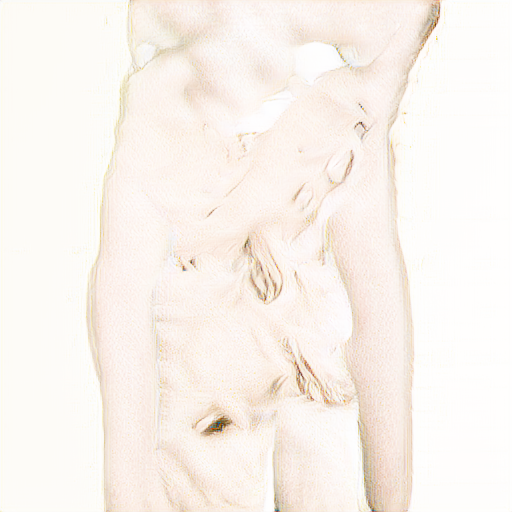

In [24]:
from PIL import Image
print(text)
print(f"Promt for CLIP: {res}")
Image.open("./_Chekhov_emphasizes_that_a_cultured_person_should_try_to_help_other_people_do_good_and_bring_happiness.png")

#DEEP PAVLOV

In [ ]:
!gsutil -m cp gs://comptech2021-ocr/levenshtein_corrector_ru.json .

In [ ]:
!pip install deeppavlov
!python -m deeppavlov install levenshtein_corrector_ru


In [ ]:
import sys
from deeppavlov import build_model, configs

CONFIG_PATH = configs.spelling_correction.brillmoore_kartaslov_ru

model_deep_pavlov = build_model(CONFIG_PATH, download=True)


In [ ]:
ocr_text = ["В дашном тексте писатель повествует о непростои судьбе жениин того времшни.","Всю жизнь они жили в строхе.", "Трудитились, ле покладая рук."]
for line in ocr_text:
    print(model_deep_pavlov([line])[0], flush=True)

# Запускаем сервер в гугл колабе, который отвечает за то, чтобы присвоить нашему выделенному серверу в гугл колабе определённый url.

In [ ]:
#in terminal
!curl -sL https://deb.nodesource.com/setup_14.x -o nodesource_setup.sh
!bash nodesource_setup.sh
!apt install nodejs

!npm install -g localtunnel
! nohup lt --port {PORT} &
time.sleep(1) 
# take url like https://wicked-skunk-16.loca.lt

In [88]:
server_url = read_server_url() # вычитываем выданный нам url

In [ ]:
server_url

In [ ]:
set_webhook(server_url) # создаём хук, чтобы телеграм отправлял нам уведомления о новых сообщениях

In [91]:
def get_image(text):
  translated_text = translate_text(target="en",text=text)
  resp = model_bert(translated_text)
  res = resp.strip().split(".")
  res = [i for i in res if len(i) > 8][-1]
  res = re.sub('[^A-Za-z]+', ' ', res)
  if "quot" in res:
    res = res.replace('quot', '')
  TEXT = res
  SAVE_EVERY = 100 
  SAVE_PROGRESS = False 
  LEARNING_RATE = 5e-2 
  ITERATIONS = 1050 
  SEED = 0 

  model = Imagine(
      text = TEXT,
      save_every = SAVE_EVERY,
      lr = LEARNING_RATE,
      iterations = ITERATIONS,
      save_progress = SAVE_PROGRESS,
      seed = SEED
  )

  for epoch in trange(1):#, desc = 'epochs'):
      for i in trange(101):#, desc = 'iteration'):
          model.train_step(epoch, i)

          if i == 0 or i % model.save_every != 0:
              continue

          filename = TEXT.replace(' ', '_')
          image = Image(f'./{filename}.png')
          #display(image)
  return filename

In [55]:
# Выводим текст, если пользователь не отправил фото.

TEXT_IMAGE_EMPTY = """Этот бот предназначен для обработки изображения и распознавания текста. Отправьте, пожалуйста, фото, текст на котором вам необходимо распознать.
"""
TEXT_IMAGE_START = """Привет, я умею распознавать рукописный текст. Отправь мне фото текста, который нужно распознать."""
ERROR_MESSAGE = """При выполнении возникла ошибка"""

#FLASK

In [ ]:
#Запускаем фласк. 
import telegram
app = Flask(__name__)

bot = telegram.Bot(token=TOKEN)
@app.route("/", methods=["GET", "POST"])
def receive_update():
    if request.method == "POST":
        print(request.json)
        chat_id = request.json["message"]["chat"]["id"]
        photos = request.json["message"].get("photo")
        
        if photos:
            photo = photos[-1]
            
            downloaded_photo = get_photo(photo['file_id'], server_url)
            downloaded_photo.save('./photos/test.png')
  
            import cv2
            img = cv2.imread('./2_8.jpg')
            cv2_imshow(img)
            ht, wd, cc= img.shape
            resolution_d_2 = 2
            resolution = max(ht, wd)
            while resolution_d_2 < resolution:
              resolution_d_2 *= 2
            image_crop = image2cropPipline(model_segment, './photos/test.png',\
                                           (resolution_d_2, resolution_d_2))
            result = pred(image_crop[0])
            deep_pavlov_result = model_deep_pavlov([*result])[0]
            send_message(chat_id, 'Идёт обработка........')
            send_message(chat_id, f'{*deep_pavlov_result}')
            
            try:
            
              filename = get_image(*deep_pavlov_result)
              bot.send_photo(chat_id=chat_id, photo=open(f'{filename}.py',\
                                                         'rb'))
            except Exception:
              send_message(chat_id, ERROR_MESSAGE)

        elif "entities" in request.json["message"]:
          if request.json["message"]['entities'][0]['type'] == 'bot_command':
            if request.json["message"]["text"] == "/start":
              send_message(chat_id, TEXT_IMAGE_START)
        else:
          send_message(chat_id,TEXT_IMAGE_EMPTY)
    return 'result'
app.run(port=PORT)

#attach image in telegram

In [70]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi
